# Creating gymnasium environment

### How to adapt this notebook to your environment ?

DQN :
- The input size of the nn depends on the size of the input state : adapt the size of the first layer 

Env: 
- Don't modify :
    - policy 
    - random_action 

- Modify :
    - init :
        - n_action : we assume the action space to be finite, and we hope small 
        - done : this attribute say if the episode is finished, it needs to be set to true when we do the reset, and we need to update in the function step
        - every attribute you need to build the function step, state, show_state
    - state : must return a batch of size 1 : 
        - typically our state is a vector of size say d, so a tensor of size (d). Here we want the function 
            to return a batch of size one , so we return a vector of size (1,d) e.g [t] where t is our size 
    - show_state 
    - reset : must update the attribute done, and your internal attribute that give the current state of the episode
    - step : take an action as a tensor (we access it by action.item() ) and returns a namedtuple Transition 
    with 4 coordinates (state,action,next_state,reward) 
            - every reward must be in [0,1] to make easier the hyperparameter finetuning
            - state and next_state must be a batch of size one (as for the function state)
            - action should be a batch of size one
            - if the episode is finished after the action, next_state must be None

### Explanations

The environment is:
 - A $N \times M$ grid of cases with $N,M \in \mathbb{N}$ supposed to be a loop track.
 - Each case is in $\{0,1,3,4\}$ such that:
   - $0 \rightarrow$ road (white)
   - $1 \rightarrow$ wall (black)
   - $STAR\_ CHAR$ (3) $\rightarrow$ starting point

 - A Car that follow some model for trajectory. The car can do the next action:
   - accelerate (add $1$ to car speed)
   - brake (divide the car speed by $1.5$)
   - turn (need to specify the angle)
   - do nothing
  
 - Possible Actions $(a,b) \in \{-1,0,1\} \times [-K,K]$ where:
   - $a=1$ for acceleration, $-1$ for brake and $0$ for nothing
   - $b>0$ for turning left with angle, $b<0$ to turn right and 0 for nothing. Note that a turn, in this environment is always in $[-K,K]$ where $K$ is the value of `env.max_turn` variable.

 - The state is a $8$ vector $V$
   - $V[0]$ is the speed of the car $\geq 0$
   - $V[i]$ (for $i \in [8]$) is the distance to the wall with rotation $90 - 30i$


To create your turn/your track, use the grid notation (for better visualisation) like env_01 and env_02. The grid is used with the matrix notation. If we denote the grid by $G$, then $G[0][0]$ is the top left case, $G[x][y]$ is the case on the $x$-th row (from top to bottom) and on the $y$-th column (from left to right).

You can also use image for that with balck pixel for wall, white for starting point, any other color will be interpreted as road.

Nevertheless, for all the other things, we use axis coordinates, i.e., $G[x][y]$ refer to the case situate at coordinate $(x,y)$. More preciselly, it is the case on the $x$-th column (from left to right) and on the $y$-th row (from bottom to top). Therefore you can simply use `plt.plot(x,y, args**)` for ploting something at coordinate $(x,y)$ (see code for more example).

### Importing Packages

In [250]:
import numpy as np
import matplotlib.pyplot as plt
from IPython import display
import random as rd
import time

from gym import Env, spaces

# For saving files
from datetime import datetime

### Coor class

In [251]:
class Coor():
    def __init__(self, coor):
        self.x = coor[0]
        self.y = coor[1]

    def get(self):
        return self.x, self.y
    
    def __str__(self):
        return "(" + str(self.x) + ", " + str(self.y) + ")"
    
    def __add__(self, coor2):
        return Coor((self.x + coor2.x, self.y + coor2.y))
    
    def __eq__(self, coor2):
        if coor2 == None:
            return False
        return (self.x==coor2.x) and (self.y==coor2.y)
    
    def __neg__(self):
        x,y = self.get()
        return Coor((-x,-y))
    
    def __sub__(self, coor2):
        coor = - coor2
        return self + coor
    
    def norm(self):
        x,y = self.get()
        return np.sqrt(x*x + y*y)
    
    def dist(self, coor2):
        return (self -coor2).norm()


### Track class

Contrary to previous environment, track are not matrix anymore.

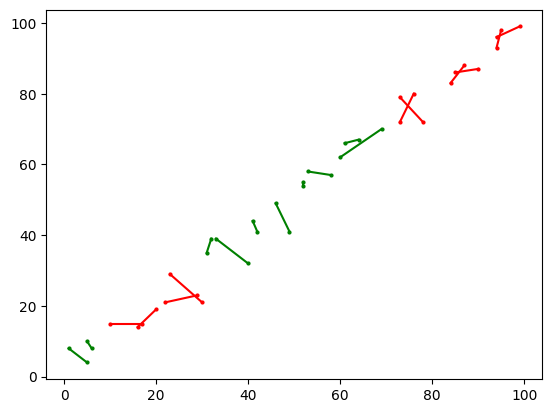

In [252]:
def intersect(coorA,coorB,coorC,coorD):
    # Return true if line segments AB and CD intersect
    def ccw(coorA, coorB, coorC):
        return (coorC.y-coorA.y) * (coorB.x-coorA.x) > (coorB.y-coorA.y) * (coorC.x-coorA.x)
    return ccw(coorA,coorC,coorD) != ccw(coorB,coorC,coorD) and ccw(coorA,coorB,coorC) != ccw(coorA,coorB,coorD)

n = 10
random_coor = lambda a,b : Coor((rd.randint(a,b), rd.randint(a,b)))
for i in range(10):
    a = random_coor(i*n, (i+1)*n)
    b = random_coor(i*n, (i+1)*n)
    c = random_coor(i*n, (i+1)*n)
    d = random_coor(i*n, (i+1)*n)
    color = "green"
    if intersect(a,b,c,d):
        color = "red"
    plt.plot([a.x, b.x], [a.y,b.y], "-o", color=color, markersize=2)
    plt.plot([c.x, d.x], [c.y,d.y], "-o", color=color, markersize=2)
plt.show()

In [253]:
RED = [255, 0, 0]
GREEN = [0, 255, 0]
BLUE = [0, 0, 255]
GREY = [70 for _ in range(3)]
WHITE = [240 for _ in range(3)]

START_CHAR = 2
CAR_CHAR = 4

def color_track(b):
    if b == START_CHAR:
        return GREEN
    elif b == 1:
        return GREY
    else:
        return WHITE
    

class Track():
    def __init__(self, tab):
        #switching height and width for plan approach
        self.height, self.width = np.array(tab).shape
        self.basic_info_track:list = np.array(tab)
        
        self.info_track:list = [[0 for _ in range(self.height)] for _ in range(self.width)]
        for x in range(self.width):
            for y in range(self.height):
                self.info_track[x][y] = self.basic_info_track[self.height-1-y][x]

        self.color_track = [[color_track(self.info_track[x][y]) for x in range(self.width)] for y in range(self.height)]

        self.start = None
        for y in range(self.height):
            for x in range(self.width):
                if self.info_track[x][y] == START_CHAR:
                    self.start = Coor((x,y))

        self.basic_alpha = 0
        self.start_line, alpha = self.create_line(self.start)

        first_mid_point = self.next_road(self.start_line[0], alpha)
        if first_mid_point == None:
            first_mid_point = self.next_road(self.start_line[1], alpha+180)
            second_mid_point = self.next_wall(first_mid_point, alpha+180)
        else:
            second_mid_point = self.next_wall(first_mid_point, alpha)
        
        self.mid_point = first_mid_point + second_mid_point
        self.mid_point.x /= 2
        self.mid_point.y /= 2
        self.mid_line, _ = self.create_line(self.mid_point)


    def create_line(self, base_coor):
        min_lenght = self.height + self.width
        for alpha in range(0, 180):
            coor1_act = self.next_wall(base_coor, alpha)
            coor2_act = self.next_wall(base_coor, alpha+180)
            lenght_act = coor1_act.dist(coor2_act)

            if lenght_act<min_lenght:
                coor1 = coor1_act
                coor2 = coor2_act
                min_lenght = lenght_act
                basic_alpha = alpha

        return (coor1, coor2), basic_alpha
    
    def does_moves_cross_start_line(self, coor1, coor2):
        return intersect(self.start_line[0], self.start_line[1], coor1, coor2)

    def get_color(self, coor:Coor):
        """return the color of the case x,y"""
        x,y = coor.get()
        return color_track(self.info_track[x][y])
    
    def is_wall(self, coor:Coor):
        """Return True if case (x,y) is a wall"""
        x,y = coor.get()
        nx,ny = int(round(x)), int(round(y))
        return (self.info_track[nx][ny] == 1)

    def get_start(self):
        """Return coordinate of start"""
        if self.start == None:
            return None
        return self.start.get()
    
    def get_end(self):
        """Return coordinate of end"""
        return self.end.get()
    
    def is_case_ridable(self, coor: Coor):
        """Return if the car can go on the coordinate or not"""
        x,y = coor.get()
        x,y = int(round(x)), int(round(y))
        if not (x>=0 and x<self.width and y>=0 and y<self.height):
            return False
        return not self.is_wall(coor)
    
    def is_move_possible(self, a:Coor, b:Coor) -> bool:
        """Return if the car can go from point a to b in straight line"""
        diff_x = b.x-a.x
        diff_y = b.y-a.y

        d = a.dist(b)
        if d<1:
            d = 1
        
        space = np.arange(0, 1, 1/d)
        for t in space:
            case = Coor((a.x+t*diff_x, a.y+t*diff_y))
            if not self.is_case_ridable(case):
                return False
        return True
    
    def is_case_in(self, coor:Coor):
        """return True is coor is in the tab"""
        return coor.x>=0 and coor.x<self.width and coor.y>=0 and coor.y<self.height
    
    def next_road(self, coor:Coor, alpha:float, dist_max=None):
        """Return the next in the line from coor to the first wall"""
        alpha = alpha % 360
        dx = np.cos(alpha * np.pi/180)
        dy = np.sin(alpha * np.pi/180)

        i = 0
        next_coor = Coor( (int(round(coor.x + i*dx)), int(round(coor.y + i*dy))) )
        while not self.is_case_ridable(next_coor):
            if ((dist_max!=None) and (coor.dist(next_coor) > dist_max)) or (not self.is_case_in(next_coor)):
                return None
            i += 1
            next_coor  = Coor( (int(round(coor.x + i*dx)), int(round(coor.y + i*dy))) )
        return next_coor

    def next_wall(self, coor:Coor, alpha:float, dist_max=None):
        """Return the next in the line from coor to the first wall"""
        alpha = alpha % 360
        dx = np.cos(alpha * np.pi/180)
        dy = np.sin(alpha * np.pi/180)

        i = 0
        next_coor = Coor( (int(round(coor.x + i*dx)), int(round(coor.y + i*dy))) )
        while self.is_case_ridable(next_coor):
            if (dist_max!=None) and (coor.dist(next_coor) > dist_max):
                break
            i += 1
            next_coor  = Coor( (int(round(coor.x + i*dx)), int(round(coor.y + i*dy))) )
        return next_coor

    def plot(self, hide=False):
        """Plot the track using matplotlib"""
        plt.imshow(self.color_track, origin='lower')

        for i in [self.start_line, self.mid_line]:
            liste_x = [coor.x for coor in i]
            liste_y = [coor.y for coor in i]
            plt.plot(liste_x, liste_y, '-', color="lightblue")
            
        plt.plot(self.start.x, self.start.y, 'x', color="green")
        plt.plot(self.mid_point.x, self.mid_point.y, 'x', color="red")
        plt.axis("off")
        if not hide:
            plt.show()


### Creating the track

In [254]:
path = "../tracks/03.png"

from matplotlib.image import imread
from PIL import Image

def info_from_real_color(tab):
    x,y,z = tab[0], tab[1], tab[2]
    if x==0 and y==0 and z==0:
        return 1
    elif x==255 and y==255 and z==255:
        return START_CHAR
    else:
        return 0

def create_track_info(path):
    img = Image.open(path)
    arr = np.array(img)
    img.close()
    return [[info_from_real_color(y) for y in x] for x in arr]

### Car class

Car has $2$ main variable:
 - speed: $v$
 - alpha: $\alpha$ suppose to be between $0$ and $360$

To calculate the $x$-speed and $y$-speed we use the next formulas:
 - $v_x = v.cos(\alpha . \frac{\pi}{180})$
 - $v_y = v.sin(\alpha . \frac{\pi}{180})$

In [255]:
"""Constant"""
MAX_SPEED = 50
MAX_TURN = 20

"""Class"""
class Car():
    def __init__(self, coor:Coor):
        self.coor: Coor = Coor((coor.x, coor.y))
        self.speed: float = 0
        self.alpha: float = 0 # The angle of the car according to unitary cicrle
        self.trajectory = [[Coor((coor.x, coor.y)), 0]]
        self.previous_speed: float = 0
        self.time = 1

        self.max_turn = MAX_TURN
        self.max_speed = MAX_SPEED

    def __str__(self):
        return "C[" + str(self.coor) + " " + str(self.speed) + " " + str(self.alpha) + "]"
    

    def accelerate(self, amont=1):
        """Increase speed of the car"""
        acceleration_constant = 1
        self.speed += acceleration_constant*amont * self.time
        self.speed = min(self.speed, self.max_speed)
        

    def brake(self, amont=1):
        """Decrease speed of the car (can't drive backward)"""
        brake_constant = 2
        self.speed -= brake_constant*amont*self.time
        if self.speed < 0:
            self.speed = 0

    def turn(self, deg):
        """Change the current rotation of the car"""
        if np.absolute(deg) > self.max_turn:
            print(deg)
            assert False
        self.alpha += deg
        self.alpha = self.alpha % 360

    def get_speed_coor(self):
        cst: float = np.pi / 180
        dx: float = self.speed * np.cos(self.alpha * cst)
        dy: float = self.speed * np.sin(self.alpha * cst)
        return Coor((dx,dy))

    def move(self):
        """Change the coordinate of the care according to its speed and alpha"""
        speed_increase = 0
        if self.previous_speed < self.speed:
            speed_increase = 1
        elif self.previous_speed > self.speed:
            speed_increase = -1
        self.previous_speed = self.speed

        dx,dy = self.get_speed_coor().get()
        self.coor.x += dx
        self.coor.y += dy
        self.trajectory.append([Coor((self.coor.x, self.coor.y)), speed_increase])

    def dic(self):
        return {"coor":self.coor, "speed":self.speed, "alpha":self.alpha, "trajectory":self.trajectory}

    def plot(self, markersize=8, vector_constant=2, show_trajectory=False, head_width=1):
        """Plot the car and is speed vectors"""
        # Plot car
        x,y = self.coor.get()
        plt.axis("off")

        # Plot 
        if show_trajectory:
            liste_x = [i[0].x for i in self.trajectory]
            liste_y = [i[0].y for i in self.trajectory]

            for i in range(1, len(self.trajectory)):
                color = "yellow"
                if self.trajectory[i][1] == 1:
                    color = "green"
                elif self.trajectory[i][1] == -1:
                    color = "red"
        
                plt.plot([liste_x[i-1], liste_x[i]], [liste_y[i-1], liste_y[i]], "-o", color=color, markersize=2)
                 
        # Plot car's directoin
        cst: float = np.pi / 180
        dx: float = np.cos(self.alpha * cst)
        dy: float = np.sin(self.alpha * cst)
        plt.arrow(x, y, dx/10, dy/10, head_width=head_width)
        plt.plot([x, x+ dx*self.speed*vector_constant], [y, y+ dy*self.speed*vector_constant], "-", color="red")
        plt.plot(x, y, "o", color='blue', markersize=markersize)


### Gym env

We need to transform a actual action $(a, \alpha) \in \{-1,0,1\} \times \{-K,...,K\}$ where $K =$ `MAX_TURN` to a action in $\{0,...,N-1\}$.

Then we need a bijection
$$\phi : \{-1,0,1\} \times \{-K,...,K\} \rightarrow \mathbb{Z}_N$$

We can take
$$\phi(a,b) = 3(b+K) + (a+1)$$

Then,
$$\phi^{-1}(x) = ((x\; mod\; 3)-1, \frac{1}{3}x -K)$$

Moreover, we have $N = 3\times 2K+1 = 6K+3$

In [256]:
MAX_SPEED = 50
MAX_TURN = 20

class RacingCar(Env):
    def __init__(self, track_path):
        super(RacingCar, self).__init__()
        # time between two frames
        self.time = 0.9 #Change this variable to "discretiser" the time. Lower value means more discretisation

        self.max_turn = int(MAX_TURN * self.time)
        self.nb_state = 6*self.max_turn + 3
        self.max_speed = int(MAX_SPEED * self.time)

        # Define an action space ranging from 0 to 3
        self.action_space = [self.int_to_action(i) for i in range(self.nb_state)]
        self.int_action_space = [i for i in range(self.nb_state)]

        self.track_info = create_track_info(track_path)
        self.track: Track = Track(self.track_info)

        # Define the anle of which we will look the distance
        self.liste_alpha = [90, 60, 30, 0, -30, -60, -90]
        self.max_dist_wall = self.track.height + self.track.width
        
        self.car: Car = self.create_car()

        self.canvas = np.array(self.track.color_track)

        self.line_goal = False #False for midline and True for start line

    def create_car(self):
        car = Car(self.track.start)
        car.max_turn = self.max_turn
        car.max_speed = self.max_speed
        car.time = self.time
        return car

    def action_to_int(self, action):
        """Transform an action (tuple) into an action (int)"""
        a,b = action
        return 3*(b+self.max_turn) + a+1
    
    def int_to_action(self, x):
        """Transform an action (int) into an action (tuple)"""
        return ((x%3)-1, int(x/3) -self.max_turn)


    def get_state(self):
        """Return actual state of the env"""
        state = [self.car.speed]
        for alpha in self.liste_alpha:
            coor = self.track.next_wall(self.car.coor, self.car.alpha + alpha, dist_max=self.max_dist_wall)
            state.append(self.car.coor.dist(coor))
        return state

    def reset(self):
        """Reset the environment"""
        self.car = self.create_car()
        self.line_goal = False
        return self.get_state(), []

    def render(self, waiting_time=0.01, show_trajectory=False, show_dist_to_wall=False):
        """Render the environment"""
        self.track.plot(hide=True)
        if show_dist_to_wall:
            for alpha in self.liste_alpha:
                coor = self.track.next_wall(self.car.coor, self.car.alpha + alpha, dist_max=self.max_dist_wall)
                plt.plot([self.car.coor.x, coor.x], [self.car.coor.y, coor.y], "-", color="grey")

        self.car.plot(show_trajectory=show_trajectory)
        display.clear_output(wait=True)
        plt.show()
        time.sleep(waiting_time)
        
    def step(self, action:int):
        """Do a step, we suppose that the action is a possible one"""
        is_done = False
        reward = 0

        x,y = self.car.coor.get()
        previous_coor = Coor((x,y))

        acc, turn = self.int_to_action(action)
        if acc==-1:
            self.car.brake()
        elif acc==1:
            self.car.accelerate()
        self.car.turn(turn)
        self.car.move()

        new_coor = self.car.coor
        reward += previous_coor.dist(new_coor)/self.max_speed

        has_crashed = False
        if not self.track.is_move_possible(previous_coor, new_coor):
            has_crashed = True
            reward = -10
            is_done = True

        has_cross_line = False
        line_goal = self.track.mid_line
        if self.line_goal:
            line_goal = self.track.start_line
        if intersect(line_goal[0], line_goal[1], previous_coor, new_coor) and not has_crashed:
            has_cross_line = True
            self.line_goal = not self.line_goal
            reward += 20

        # reward -= 0.5
        return self.get_state(), reward, is_done, has_crashed, [has_cross_line]
    
    def random_action(self, p_accel=0.25, p_brake=0.25, p_turn=0.5):
        """Return random possible action according to probability"""
        action = [0,0]
        rd_accel = rd.random()
        if rd_accel <= p_accel:
            action[0] = 1
        elif rd_accel <= p_accel + p_brake:
            action[0] = -1
        
        if rd.random() <= p_turn:
            action[1] = ((-1)**(rd.randint(0,1))) * rd.randint(-self.max_turn, self.max_turn)
        return tuple(action)

### Env example

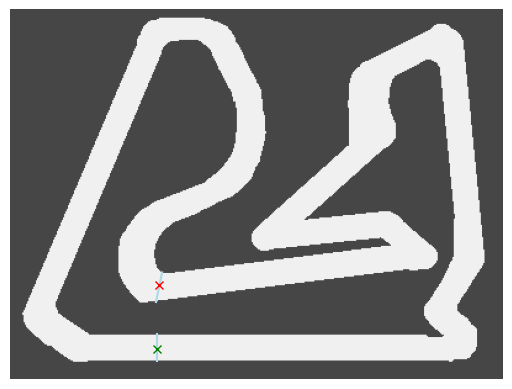

Start point: (119, 24)    start line: (119, 36) (119, 14)
Mid point  : (120.5, 76.0)


In [257]:
Env = RacingCar(path)
Env.track.plot()
print("Start point:", Env.track.start, "   start line:", Env.track.start_line[0], Env.track.start_line[1])
print("Mid point  :", Env.track.mid_point)

In [258]:
print(Env.nb_state)
print(Env.action_space)
for i in range(Env.nb_state):
    acc,turn = Env.int_to_action(i)
    if (np.absolute(turn) > Env.max_turn) or (np.absolute(Env.action_space[i][1]) > Env.max_turn):
        assert False

111
[(-1, -18), (0, -18), (1, -18), (-1, -17), (0, -17), (1, -17), (-1, -16), (0, -16), (1, -16), (-1, -15), (0, -15), (1, -15), (-1, -14), (0, -14), (1, -14), (-1, -13), (0, -13), (1, -13), (-1, -12), (0, -12), (1, -12), (-1, -11), (0, -11), (1, -11), (-1, -10), (0, -10), (1, -10), (-1, -9), (0, -9), (1, -9), (-1, -8), (0, -8), (1, -8), (-1, -7), (0, -7), (1, -7), (-1, -6), (0, -6), (1, -6), (-1, -5), (0, -5), (1, -5), (-1, -4), (0, -4), (1, -4), (-1, -3), (0, -3), (1, -3), (-1, -2), (0, -2), (1, -2), (-1, -1), (0, -1), (1, -1), (-1, 0), (0, 0), (1, 0), (-1, 1), (0, 1), (1, 1), (-1, 2), (0, 2), (1, 2), (-1, 3), (0, 3), (1, 3), (-1, 4), (0, 4), (1, 4), (-1, 5), (0, 5), (1, 5), (-1, 6), (0, 6), (1, 6), (-1, 7), (0, 7), (1, 7), (-1, 8), (0, 8), (1, 8), (-1, 9), (0, 9), (1, 9), (-1, 10), (0, 10), (1, 10), (-1, 11), (0, 11), (1, 11), (-1, 12), (0, 12), (1, 12), (-1, 13), (0, 13), (1, 13), (-1, 14), (0, 14), (1, 14), (-1, 15), (0, 15), (1, 15), (-1, 16), (0, 16), (1, 16), (-1, 17), (0, 17),

[]

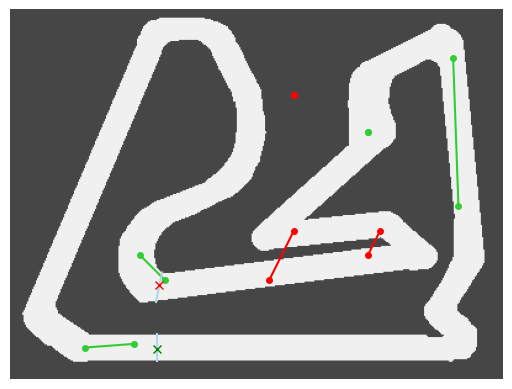

In [259]:
moves = [[Coor((60, 25)), Coor((100,28))],
         [Coor((125, 80)), Coor((105, 100))],
         [Coor((300,120)), Coor((290, 100))],
         [Coor((230,120)), Coor((210, 80))],
         [Coor((363.5,140)), Coor((359.2, 260))],
         [Coor((230, 230)), Coor((230, 230))],
         [Coor((290, 200)), Coor((290, 200))]]

for coors in moves:
    res = Env.track.is_move_possible(coors[0], coors[1])
    color = "limegreen"
    if not res:
        color = "red"
    plt.plot([coors[0].x, coors[1].x], [coors[0].y, coors[1].y], "-o", markersize=4, color=color)

Env.track.plot(hide=True)
plt.plot()

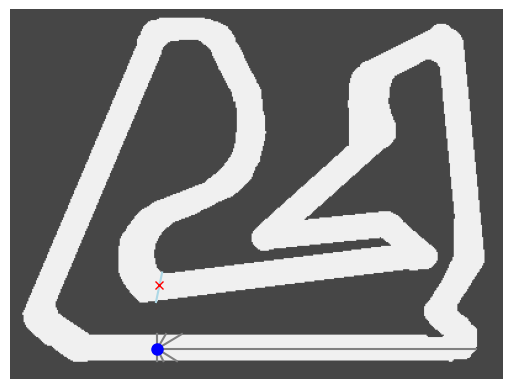

0.9 18
0.9 18


In [260]:
Env.render(show_dist_to_wall=True, show_trajectory=True)

print(Env.time, Env.max_turn)
print(Env.car.time, Env.car.max_turn)

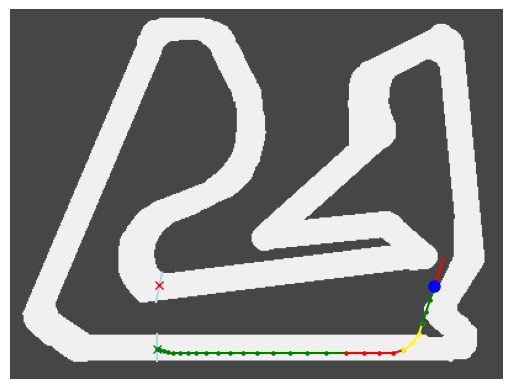

[11.700000000000001, 0.056467012277334375, 0.056467012277334375, 0.056467012277334375, 0.056467012277334375, 0.056467012277334375, 0.056467012277334375, 0.056467012277334375]


In [261]:
Env.reset()

actions = [(1,-10), (1, -10), (1,0), (1,0), (1,10), (1, 10), (1,0), (1,0), (1,0), (1,0), (1,0), (1,0), (1,0), (1,0), (1,0), (1,0), (1,0),
           (1,0), (-1,0), (-1,0), (-1,0), (-1, Env.max_turn), (0, Env.max_turn), (0, Env.max_turn), (0, Env.max_turn), (1,0), (1,0), (1,0)]

for action in actions:
    if np.absolute(action[1]) <= Env.max_turn:
        Env.step(Env.action_to_int(action))
        Env.render(show_trajectory=True, show_dist_to_wall=True)
    
print(Env.get_state())
Env.close()

### Crossing start line

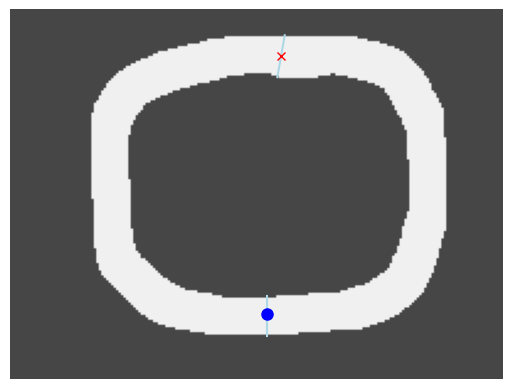

In [262]:
path = "../tracks/01.png"
env2 = RacingCar(path)
env2.render()
env2.close()

# Torch env

In [263]:
import torch 
import torch.nn as nn 
import torch.functional as F
import torch.optim as optim

# structure to save transitions 
from collections import namedtuple , deque
Transition = namedtuple("Transition",["state","action","next_state","reward"])

### ReplayMem

In [264]:
class ReplayMemory():
    def __init__(self,maxlen : int):
        self.memory_ = deque(maxlen=maxlen)

    def push(self,x : Transition):
        self.memory_.append(x)

    def sample(self,batch_size : int) -> list[Transition]:
        return rd.sample(self.memory_,batch_size)
    
    def clear(self):
        return self.memory_.clear()
    
    def __len__(self):
        return len(self.memory_)

### DQN

In [265]:
class DQN(nn.Module):
    def __init__(self,layer_size,state_size,action_n):
        super(DQN,self).__init__()
        self.network = nn.Sequential(
            nn.Linear(state_size,layer_size),
            nn.ReLU(),

            nn.Linear(layer_size,layer_size),
            nn.ReLU(),

            nn.Linear(layer_size,layer_size),
            nn.ReLU(),

            nn.Linear(layer_size,action_n),
        )

    def forward(self,x):
        return self.network(x)
    
    def save(self,filename : str = None):
        if (filename == None):
            filename = datetime.now().strftime("%Y-%m-%d_%H:%M:%S")
        torch.save(self.state_dict(),filename)

    def load(self,filename : str):
        self.load_state_dict(torch.load(filename, weights_only=True))

### Env

In [266]:
class Env():
    def __init__(self, track_name):
        """ track_name is the name of the track file"""
        # Toujours là
        self.done = False

        # Pour faire step, reset, state pour cette implementation
        self.env = RacingCar(track_name)
        self.state_gym,_ = self.env.reset()
        self.n_action = self.env.nb_state

        # Décrit le model actuel
        self.model = DQN(400,8,self.n_action)

        # Décrit les transitions observées jusqu'à présent
        self.memory = ReplayMemory(10000)

        # Pour normaliser la Q table
        self.discount_factor = 0.9

    def state(self):
        """ On définit un état comme étant un batch de taille 1 ou None"""
        if (self.state_gym == None or self.done) :
            return None
        else :
            arr = np.array(self.env.get_state())
            arr = arr / max(MAX_SPEED, self.env.max_dist_wall) #To normalize the array
            return torch.tensor([arr],dtype=torch.float)

    def show_state(self):
        self.env.render(show_trajectory=True)

    def reset(self):
        """Reset the environment"""
        self.state_gym , _ = self.env.reset()
        self.done = False
    
    def dist(state):
        """Calcule la longueur d'un plus court chemin entre state et goal (sous forme d'un flotant)"""
        goal = torch.tensor([[11,3]],dtype=torch.float)
        start = torch.tensor([[0,3]],dtype=torch.float)
        if (torch.equal(state,start)):
           return torch.tensor(13,dtype=torch.float)
        else :
           return torch.sum(torch.abs(state-goal))
       
    def step(self,action : torch.tensor) :
        """ Fais un pas depuis l'état actuel via l'action donnée et renvoit la transition observéex
            Une action est un tenseur contenant un seul scalaire """
        if (self.done):
            raise(ValueError("Trying to move from a final state"))

        prev_state = self.state()

        # do the step and update the new gym state
        acc, turn = self.env.int_to_action(action.item())
        if np.absolute(turn) > self.env.max_turn:
            print(action.item(), (acc, turn))
            
        self.state_gym,reward,terminated,truncated,_ = self.env.step(action.item())
        self.done = terminated or truncated

        next_state = self.state()

        reward_normalizer = 20
        qtable_normalizer = 1/(1-self.discount_factor)
        reward = torch.tensor(reward/(reward_normalizer*qtable_normalizer), dtype=torch.float).reshape((1,1))
        action = torch.tensor(action.item()).reshape((1,1))

        transition = Transition(prev_state, action, next_state , reward)
        return transition
    
    def policy(self):
        if (self.done):
            raise(ValueError("Trying to predict a move from a final state"))
        return self.model(self.state()).max(1).indices.reshape((1,1))
    
    def random_action(self) -> torch.tensor :
        if (self.done):
            raise(ValueError("Trying to sample a move from a final state"))
        action = rd.randint(0,self.n_action-1)
        return torch.tensor(action).reshape((1,1))
    

In [267]:
def optimize(env : Env,optimizer,criterion,batch_size,discount_factor):
    if (len(env.memory) < batch_size) :
        return 

    # A list of batch_size transtions
    transition = env.memory.sample(batch_size)

    # A tuple with four coordinates : 
    # state -> a batch of size batch_size of states 
    # action -> a batch of size batch_size of actions
    # ect
    batch = Transition(*zip(*transition))

    state_batch = torch.cat(batch.state)
    action_batch = torch.cat(batch.action)
    reward_batch = torch.cat(batch.reward)

    # Batch of size batch_size of the Qvalue predicted by our current model, for the state and action of a transtion
    predicted = env.model(state_batch).gather(1,action_batch)

    next_state_value = torch.zeros((batch_size,1))

    non_final_mask = torch.tensor(tuple(map(lambda s: s is not None, batch.next_state)), dtype=torch.bool )
    if non_final_mask.any():
        non_final_next_state = torch.cat([s for s in batch.next_state if s is not None])
        with torch.no_grad():
            next_state_value[non_final_mask] = env.model(non_final_next_state).max(1).values.unsqueeze(1)

    expected = reward_batch + (discount_factor * next_state_value)

    optimizer.zero_grad()
    loss = criterion(predicted,expected)
    loss.backward()
    torch.nn.utils.clip_grad_value_(env.model.parameters(), 100)
    optimizer.step()

In [268]:
def training(env:Env):
    #env.model.load(filename)
    filename =  "saved_model/"  + datetime.now().strftime("%Y-%m-%d_%H:%M:%S")

    # Hyperparameters
    batch_size = 40
    epochs = 5000
    max_episode_duration = 1000 * 1/env.env.time
    epsilon_max = 1
    epsilon_min = 0.01
    epsilon_decay = 40.
    lr = 1e-4
    discount_factor = 0.9
    env.discount_factor = discount_factor
    optimizer = optim.AdamW(env.model.parameters(), lr=lr, amsgrad=True)
    criterion = nn.SmoothL1Loss()

    env.memory.clear()
    reward_history = []

    for i in range(epochs):
        env.reset()
        epsilon = epsilon_min + (epsilon_max-epsilon_min)*np.exp(-i/epsilon_decay)
        it_counter = 0
        reward = 0
        while(not(env.done) and it_counter < max_episode_duration):
            it_counter += 1
            # Chose an action
            if (rd.random() <= epsilon):
                action = env.random_action()
            else:
                with torch.no_grad() :
                    action = env.policy()

            # Apply the transition and save it in memory
            transition = env.step(action)
            reward += (transition.reward).item()
            env.memory.push(transition)
            
            # Optimize the model according to the observed reward
            #optimizer_one_by_one(env,transition,optimizer,criterion,discount_factor)
            optimize(env,optimizer,criterion,batch_size,discount_factor)
            #optimize_weak(env,optimizer,criterion,batch_size,discount_factor)
            #env.show_state()
            if (i%100 == 0) :
                env.show_state()
        if (i%100 == 0):
            print("done", i)

        # if (i%100 == 0) :
        #         env.show_state()
        normalizer = 1
        reward_history.append(reward*normalizer)

    window = 20*[1/20]
    reward_history = np.convolve(reward_history, window ,  mode="valid")
    plt.plot(reward_history)
    plt.show()

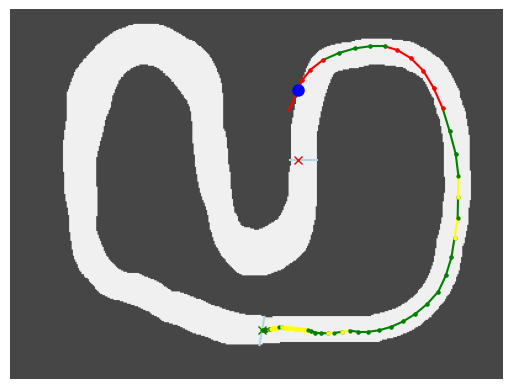

done 400


KeyboardInterrupt: 

In [269]:
myenv = Env("../tracks/02.png")
print(myenv.n_action)
training(myenv)

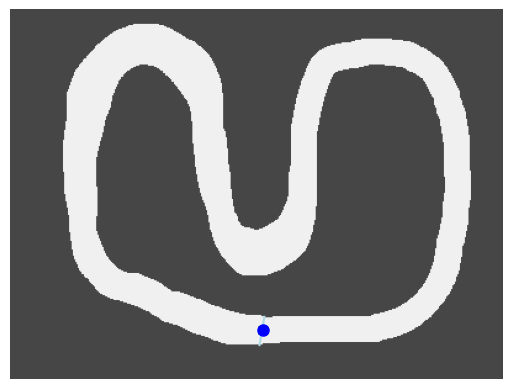

In [ ]:
for i in range(1):
    myenv.reset()
    while(myenv.done == False) :
        myenv.step(myenv.policy())
        myenv.show_state()